In [1]:
import pickle
import os
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

blue = '#00AEEF'
red = '#F15A2A'

In [2]:
from src.model import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, get_sample_from_num_swaps, test_network, get_cos_sim_torch
from src.utils.plotting import compare_distributions_12
from Figure_6_utils import sensory_semantic_replay
from network_parameters import network_parameters


In [3]:
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [4]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [5]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_sensory_sen_projection"] = True
network_parameters["mtl_sensory_sen_size"] = 30
network_parameters["max_post_mtl_sensory_sen"] = 1
network_parameters["max_pre_mtl_sensory_sen"] = np.inf

recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_semantic", "mtl_sensory", "ctx", "mtl"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf

num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 5 * num_episodes
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [6]:

def episode_recall(net, ep, num_swaps):
    num_iterations = 10
    mtl_sensory_corrupted =  get_sample_from_num_swaps(ep[:net.mtl_sensory_size], num_swaps)
    mtl_0 = torch.zeros((net.mtl_size))
    mtl_0[:net.mtl_sensory_size] = mtl_sensory_corrupted
    mtl = mtl_0.clone()
    #ctx = net.activation(F.linear(net.ctx_mtl, mtl), 'ctx')[0]
    #mtl_semantic = net.activation(F.linear(net.mtl_semantic_ctx, ctx), 'mtl_semantic')[0]
    #mtl[net.mtl_sensory_size:] = mtl_semantic
    for iteration in range(num_iterations):
      mtl_hat = F.linear(net.mtl_mtl, mtl)
      mtl, _ = net.activation(mtl_hat, 'mtl')

    recall_sensory = get_cos_sim_torch(mtl[:net.mtl_sensory_size], ep[:net.mtl_sensory_size])
    recall_semantic = get_cos_sim_torch(mtl[net.mtl_sensory_size:], ep[net.mtl_sensory_size:])
    recall = get_cos_sim_torch(mtl, ep)
    return mtl_0, mtl, recall_sensory, recall_semantic, recall




def get_recalls(network):
    num_trials = 10
    recalls = []
    recalls_semantic = []
    recalls_sensory = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )

        for episode in torch.stack(network.activity_recordings["mtl"], axis=0):
            mtl_0, mtl, recall_sensory, recall_semantic, recall = episode_recall(network, episode, num_swaps=5)
            recalls.append(recall)
            recalls_semantic.append(recall_semantic)
            recalls_sensory.append(recall_sensory)

    return recalls, recalls_sensory, recalls_semantic


def get_replays(network):

    def get_max_overlap(replayed, prototpyes):
        cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
        max_sim = torch.max(torch.stack(cos_sims, dim=0))
        return max_sim.item()

    num_trials = 100
    num_replays = 5
    num_iterations = 10
    replays = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )


        for replay in range(num_replays):
            mtl = torch.randn(network.mtl_size)
            for iteration in range(num_iterations):
                mtl_hat = F.linear(network.mtl_mtl, mtl)
                mtl, _ = network.activation(mtl_hat, 'mtl')
            replays.append(get_max_overlap(mtl,torch.stack(network.activity_recordings["mtl"], axis=0)))

    return replays

In [7]:
network_intact = torch.load("checkpoints/network_5_blocked_best.pt", weights_only=False)

In [8]:
network_intact.init_recordings(recording_parameters)
network_intact.frozen = False
network_intact.activity_recordings_rate = 1
network_intact.connectivity_recordings_rate = np.inf


input, input_episodes, input_latents, network = test_network(
    network_intact, input_params, sleep=False, print_rate=50
)

0


In [9]:
mtl_sensory_0 = torch.stack(network_intact.activity_recordings["mtl_sensory"], axis=0)[network_intact.awake_indices][-1]
mtl_0 = torch.zeros(network_intact.mtl_size)
mtl_0[:network.mtl_sensory_size] = mtl_sensory_0
mtl = network.pattern_complete("mtl", mtl_0)

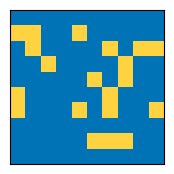

In [10]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl_sensory_0.reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b1.svg', dpi=300, transparent=True)

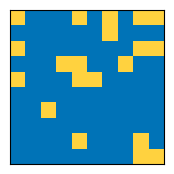

In [11]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl[:network.mtl_sensory_size].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b2.svg', dpi=300, transparent=True)

In [12]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [13]:

recalls_intact = get_recalls(network_intact)
replays_intact = get_replays(network_intact)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [14]:
network_scrambled = deepcopy(network_intact)

# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network_scrambled.mtl_semantic_ctx), dim=1)
# Apply the permutations
network_scrambled.mtl_semantic_ctx = torch.gather(network_scrambled.mtl_semantic_ctx, dim=1, index=perms)
# Freeze ctx to mtl semantic connections
network_scrambled.mtl_semantic_ctx_lmbda = 0
network_scrambled.mtl_semantic_b[:] = -1

In [15]:

recalls_scrambled = get_recalls(network_scrambled)
replays_scrambled = get_replays(network_scrambled)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


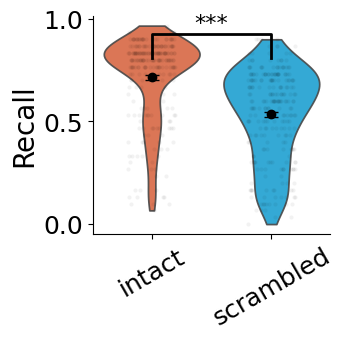

In [16]:
dist1 = ('intact', recalls_intact[0])
dist2 = ('scrambled', recalls_scrambled[0])

palette = {
    "intact": red, 
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6c.svg', dpi=300, transparent=True)


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


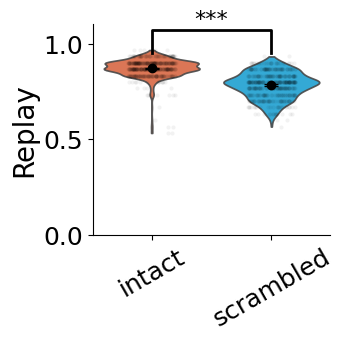

In [17]:
dist1 = ('intact', replays_intact)
dist2 = ('scrambled', replays_scrambled)

palette = {
    "intact": red,   # light blue
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Replay", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6e.svg', dpi=300, transparent=True)

In [18]:
num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 200
input_params["mean_duration"] = 1
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [19]:
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0


In [20]:
mtl_sen_episodes = torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.awake_indices][-200:]

In [21]:
mtl_semantic_episodes = torch.stack(network.activity_recordings["mtl_semantic"], axis=0)[network.awake_indices][-200:]

In [22]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_sen_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_sen_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [23]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [24]:
def get_recall(network_path, recording_parameters, input_params, latent_specs, mode, seed, get_recordings=False):
    print(f"starting simulation {mode} - {seed}")


    network = torch.load(network_path, weights_only=False)

    if mode == 'scrambled':
        # Generate independent permutations for each row
        perms = torch.argsort(torch.rand_like(network.mtl_semantic_ctx), dim=1)
        # Apply the permutations
        network.mtl_semantic_ctx = torch.gather(network.mtl_semantic_ctx, dim=1, index=perms)
        # Freeze ctx to mtl semantic connections
        network.mtl_semantic_ctx_lmbda = 0
        network.mtl_semantic_b[:] = -1

    num_episodes_range = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]
    num_swaps_range = [2]

    len_episode_range = len(num_episodes_range)
    len_swaps_range = len(num_swaps_range)

    # Allocate trial axis (first dim)
    recall_sensory = torch.zeros((len_episode_range, len_swaps_range))
    recall_semantic = torch.zeros((len_episode_range, len_swaps_range))
    recall = torch.zeros((len_episode_range, len_swaps_range))
    
    if get_recordings:
        mtl_input_recordings_all = []
        mtl_corrupted_recordings_all = []
        mtl_recall_recordings_all = []




    for num_episodes_idx, num_episodes in enumerate(num_episodes_range):

        seed_everything(seed)

        input_params = {}
        input_params["num_days"] = 1
        input_params["day_length"] = 5 * num_episodes
        input_params["mean_duration"] = 5
        input_params["fixed_duration"] = True
        input_params["num_swaps"] = 2

        latent_specs = {}
        latent_specs["num"] = 2
        latent_specs["total_sizes"] = [50, 50]
        latent_specs["act_sizes"] = [10, 10]
        latent_specs["dims"] = [5, 5]
        latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
        #atent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
        input_params["latent_space"] = LatentSpace(**latent_specs)

        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=np.inf
        )

        for num_swap_idx, num_swap in enumerate(num_swaps_range):
            mtl_input_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            mtl_corrupted_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            mtl_recall_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            rd = torch.zeros(input_params["day_length"])
            rs = torch.zeros(input_params["day_length"])
            r = torch.zeros(input_params["day_length"])
            for episode_idx, episode in enumerate(torch.stack(network.activity_recordings["mtl"], dim=0)[1:]):
                mtl_0, mtl, rd[episode_idx], rs[episode_idx], r[episode_idx] = episode_recall(network, episode, num_swap)
                if get_recordings:
                    mtl_input_recordings[episode_idx] = episode.clone()
                    mtl_corrupted_recordings[episode_idx] = mtl_0.clone()
                    mtl_recall_recordings[episode_idx] = mtl.clone()
            recall_sensory[num_episodes_idx, num_swap_idx] = rd.mean()
            recall_semantic[num_episodes_idx, num_swap_idx] = rs.mean()
            recall[num_episodes_idx, num_swap_idx] = r.mean()

        if get_recordings:
            mtl_input_recordings_all.append(mtl_input_recordings)
            mtl_corrupted_recordings_all.append(mtl_corrupted_recordings)
            mtl_recall_recordings_all.append(mtl_recall_recordings)

    if get_recordings:
        return mtl_input_recordings_all, mtl_corrupted_recordings_all, mtl_recall_recordings_all, recall_sensory, recall_semantic, recall

    return recall_sensory, recall_semantic, recall

In [25]:
network_path = "checkpoints/network_5_blocked_best.pt"
mtl_input_recordings_all, mtl_corrupted_recordings_all, mtl_recall_recordings_all, recall_sensory, recall_semantic, recall = get_recall(network_path,recording_parameters, input_params, latent_specs, mode='intact', seed=0, get_recordings=True)

starting simulation intact - 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [26]:
network_intact = torch.load("checkpoints/network_5_blocked_best.pt", weights_only=False)

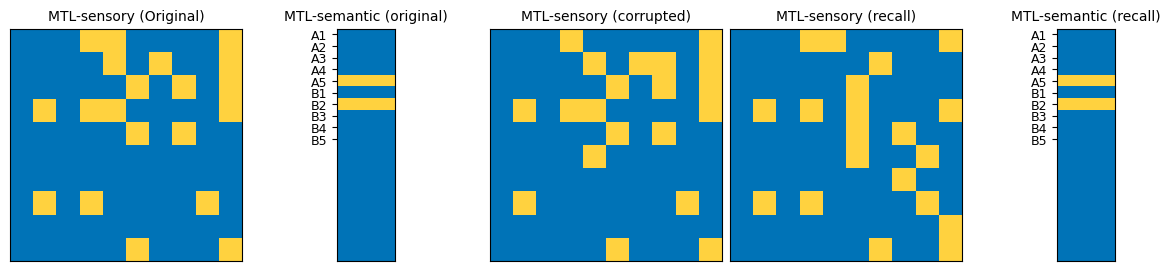

In [27]:
num_episodes_index = 0
pattern_index = 0

# --- Helpers ---
def add_group_labels(ax, NA=5, NB=5, N_rows=10):
    M = N_rows // (NA + NB)
    labels_A = [f"A{i+1}" for i in range(NA)]
    labels_B = [f"B{i+1}" for i in range(NB)]
    labels = labels_A + labels_B
    positions = [M * i for i in range(NA + NB)]
    ax.set_yticks(positions)
    ax.set_yticklabels(labels, fontsize=9)

def to_matrix_torch(vec, ncols: int):
    assert isinstance(vec, torch.Tensor)
    total = vec.numel()
    return vec.reshape(total // ncols, ncols)


ne = num_episodes_index
pi = pattern_index
D = network_intact.mtl_sensory_size
ord_idx = network_intact.ordered_indices_mtl_semantic 

sensory_input   = mtl_input_recordings_all[ne][pi][:D]
semantic_input  = mtl_input_recordings_all[ne][pi][D:][ord_idx]
sensory_corrupt = mtl_corrupted_recordings_all[ne][pi][:D]
semantic_recall = mtl_recall_recordings_all[ne][pi][D:][ord_idx]
sensory_recall  = mtl_recall_recordings_all[ne][pi][:D]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.6), constrained_layout=True)

# Panel 1: Input sensory
mat = to_matrix_torch(sensory_input, ncols=10)
im0 = axs[0].imshow(mat, cmap=blue_yellow)
axs[0].set_title("MTL-sensory (Original)", fontsize=10)
axs[0].set_xticks([]); axs[0].set_yticks([])

# Panel 2: Input semantic
mat = to_matrix_torch(semantic_input, ncols=5)
im1 = axs[1].imshow(mat, cmap=blue_yellow)
axs[1].set_title("MTL-semantic (original)", fontsize=10)
axs[1].set_xticks([])
add_group_labels(axs[1], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

# Panel 3: Corrupted sensory
mat = to_matrix_torch(sensory_corrupt, ncols=10)
im2 = axs[2].imshow(mat, cmap=blue_yellow)
axs[2].set_title("MTL-sensory (corrupted)", fontsize=10)
axs[2].set_xticks([]); axs[2].set_yticks([])


# Panel 5: Recall sensory
mat = to_matrix_torch(sensory_recall, ncols=10)
im4 = axs[3].imshow(mat, cmap=blue_yellow)
axs[3].set_title("MTL-sensory (recall)", fontsize=10)
axs[3].set_xticks([]); axs[3].set_yticks([])

# Panel 4: Recall semantic
mat = to_matrix_torch(semantic_recall, ncols=5)
im3 = axs[4].imshow(mat, cmap=blue_yellow)
axs[4].set_title("MTL-semantic (recall)", fontsize=10)
axs[4].set_xticks([])
add_group_labels(axs[4], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

fig.savefig("Figures_SVG/6_supp_1.svg", dpi=300, transparent=True)

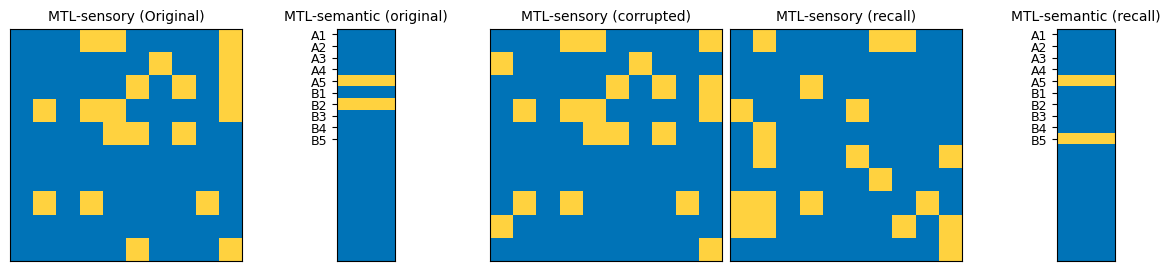

In [28]:
num_episodes_index = -1
pattern_index = 0

# --- Helpers ---
def add_group_labels(ax, NA=5, NB=5, N_rows=10):
    M = N_rows // (NA + NB)
    labels_A = [f"A{i+1}" for i in range(NA)]
    labels_B = [f"B{i+1}" for i in range(NB)]
    labels = labels_A + labels_B
    positions = [M * i for i in range(NA + NB)]
    ax.set_yticks(positions)
    ax.set_yticklabels(labels, fontsize=9)

def to_matrix_torch(vec, ncols: int):
    assert isinstance(vec, torch.Tensor)
    total = vec.numel()
    return vec.reshape(total // ncols, ncols)


ne = num_episodes_index
pi = pattern_index
D = network_intact.mtl_sensory_size
ord_idx = network_intact.ordered_indices_mtl_semantic 

sensory_input   = mtl_input_recordings_all[ne][pi][:D]
semantic_input  = mtl_input_recordings_all[ne][pi][D:][ord_idx]
sensory_corrupt = mtl_corrupted_recordings_all[ne][pi][:D]
semantic_recall = mtl_recall_recordings_all[ne][pi][D:][ord_idx]
sensory_recall  = mtl_recall_recordings_all[ne][pi][:D]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.6), constrained_layout=True)

# Panel 1: Input sensory
mat = to_matrix_torch(sensory_input, ncols=10)
im0 = axs[0].imshow(mat, cmap=blue_yellow)
axs[0].set_title("MTL-sensory (Original)", fontsize=10)
axs[0].set_xticks([]); axs[0].set_yticks([])

# Panel 2: Input semantic
mat = to_matrix_torch(semantic_input, ncols=5)
im1 = axs[1].imshow(mat, cmap=blue_yellow)
axs[1].set_title("MTL-semantic (original)", fontsize=10)
axs[1].set_xticks([])
add_group_labels(axs[1], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

# Panel 3: Corrupted sensory
mat = to_matrix_torch(sensory_corrupt, ncols=10)
im2 = axs[2].imshow(mat, cmap=blue_yellow)
axs[2].set_title("MTL-sensory (corrupted)", fontsize=10)
axs[2].set_xticks([]); axs[2].set_yticks([])


# Panel 5: Recall sensory
mat = to_matrix_torch(sensory_recall, ncols=10)
im4 = axs[3].imshow(mat, cmap=blue_yellow)
axs[3].set_title("MTL-sensory (recall)", fontsize=10)
axs[3].set_xticks([]); axs[3].set_yticks([])

# Panel 4: Recall semantic
mat = to_matrix_torch(semantic_recall, ncols=5)
im3 = axs[4].imshow(mat, cmap=blue_yellow)
axs[4].set_title("MTL-semantic (recall)", fontsize=10)
axs[4].set_xticks([])
add_group_labels(axs[4], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

fig.savefig("Figures_SVG/6_supp_2.svg", dpi=300, transparent=True)

In [29]:

num_cpu = 100
modes = ["intact", "scrambled"]
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [30]:
network_path = "checkpoints/network_5_blocked_best.pt"
experiment_params = [(network_path,recording_parameters, input_params, latent_specs, mode, seed) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(get_recall, experiment_params)

starting simulation intact - 0
starting simulation intact - 1
starting simulation intact - 2
starting simulation intact - 3starting simulation intact - 4
starting simulation intact - 5

starting simulation intact - 6
starting simulation intact - 10
starting simulation intact - 11
starting simulation intact - 12
starting simulation intact - 13starting simulation intact - 14
starting simulation intact - 15

starting simulation intact - 16starting simulation intact - 19starting simulation intact - 17
starting simulation intact - 20starting simulation intact - 18starting simulation intact - 22

starting simulation intact - 24
starting simulation intact - 21starting simulation intact - 25


starting simulation intact - 23


starting simulation intact - 28starting simulation intact - 29starting simulation intact - 7
starting simulation intact - 27
starting simulation intact - 9starting simulation intact - 26
starting simulation intact - 30


starting simulation intact - 31

starting simulati

In [31]:
def save_results(results_list, filename):


    results = {}
    results["recall_sensory"] = []
    results["recall_semantic"] = []
    results["recall"] = []


    for recall_sensory, recall_semantic, recall in results_list:


        results["recall_sensory"].append(recall_sensory)
        results["recall_semantic"].append(recall_semantic)
        results["recall"].append(recall)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_network_capacity.pickle')

In [32]:
with open('Data/{}'.format('fig_6_network_capacity.pickle'), 'rb') as handle:
    results = pickle.load(handle)

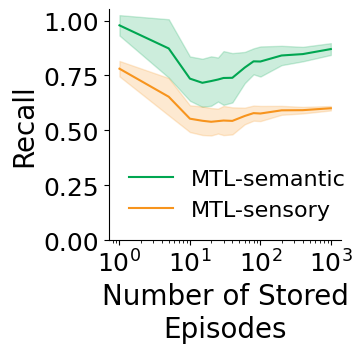

In [33]:
recall_semantic_intact = torch.stack(results["recall_semantic"][:num_seeds])
recall_sensory_intact = torch.stack(results["recall_sensory"][:num_seeds])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
semantic_mean = recall_semantic_intact.mean(axis=0).squeeze(1)
semantic_std  = recall_semantic_intact.std(axis=0).squeeze(1)

sensory_mean  = recall_sensory_intact.mean(axis=0).squeeze(1)
sensory_std   = recall_sensory_intact.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# semantic
plt.plot(x, semantic_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    semantic_mean - semantic_std,
    semantic_mean + semantic_std,
    color=green,
    alpha=0.2
)

# sensory
plt.plot(x, sensory_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    sensory_mean - sensory_std,
    sensory_mean + sensory_std,
    color=orange,
    alpha=0.2
)

plt.legend(frameon=False, fontsize=16)
plt.xscale("log")
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d.svg', dpi=300, transparent=True)

<Figure size 300x300 with 0 Axes>

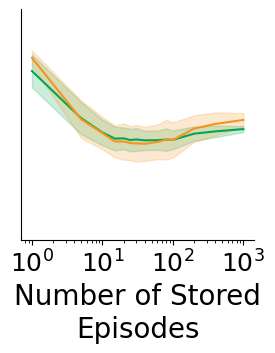

In [34]:
fig = plt.figure(figsize=((3, 3)))
recall_semantic_scrambled = torch.stack(results["recall_semantic"][num_seeds:])
recall_sensory_scrambled = torch.stack(results["recall_sensory"][num_seeds:])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
semantic_mean = recall_semantic_scrambled.mean(axis=0).squeeze(1)
semantic_std  = recall_semantic_scrambled.std(axis=0).squeeze(1)

sensory_mean  = recall_sensory_scrambled.mean(axis=0).squeeze(1)
sensory_std   = recall_sensory_scrambled.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# semantic
plt.plot(x, semantic_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    semantic_mean - semantic_std,
    semantic_mean + semantic_std,
    color=green,
    alpha=0.2
)

# sensory
plt.plot(x, sensory_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    sensory_mean - sensory_std,
    sensory_mean + sensory_std,
    color=orange,
    alpha=0.2
)


plt.xscale("log")
plt.yticks([])
plt.ylim([0, 1])


plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
#plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d2.svg', dpi=300, transparent=True)

In [35]:
network_intact = torch.load("checkpoints/network_5_blocked_median.pt", weights_only=False)

In [36]:
recalls_intact = get_recalls(network_intact)
replays_intact = get_replays(network_intact)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [37]:
network_scrambled = deepcopy(network_intact)

# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network_scrambled.mtl_semantic_ctx), dim=1)
# Apply the permutations
network_scrambled.mtl_semantic_ctx = torch.gather(network_scrambled.mtl_semantic_ctx, dim=1, index=perms)
# Freeze ctx to mtl semantic connections
network_scrambled.mtl_semantic_ctx_lmbda = 0
network_scrambled.mtl_semantic_b[:] = -1

In [38]:
recalls_scrambled = get_recalls(network_scrambled)
replays_scrambled = get_replays(network_scrambled)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


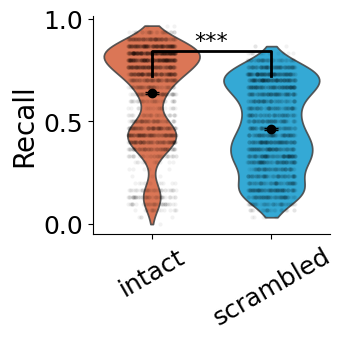

In [39]:
dist1 = ('intact', recalls_intact[0])
dist2 = ('scrambled', recalls_scrambled[0])

palette = {
    "intact": red, 
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6c_supp.svg', dpi=300, transparent=True)


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


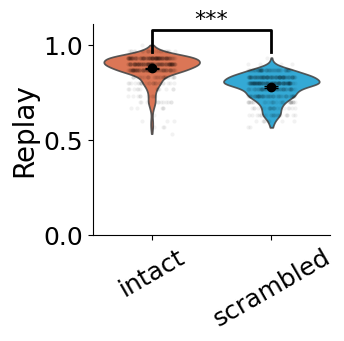

In [40]:
dist1 = ('intact', replays_intact)
dist2 = ('scrambled', replays_scrambled)

palette = {
    "intact": red,   # light blue
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Replay", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6e_supp.svg', dpi=300, transparent=True)

In [41]:
network_path = "checkpoints/network_5_blocked_median.pt"
experiment_params = [(network_path,recording_parameters, input_params, latent_specs, mode, seed) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(get_recall, experiment_params)

starting simulation intact - 0
starting simulation intact - 1
starting simulation intact - 2
starting simulation intact - 3starting simulation intact - 4

starting simulation intact - 5
starting simulation intact - 6
starting simulation intact - 7
starting simulation intact - 8
starting simulation intact - 9starting simulation intact - 10starting simulation intact - 11
starting simulation intact - 12

starting simulation intact - 16starting simulation intact - 15
starting simulation intact - 17

starting simulation intact - 21
starting simulation intact - 25starting simulation intact - 13starting simulation intact - 26
starting simulation intact - 30starting simulation intact - 14starting simulation intact - 24starting simulation intact - 20starting simulation intact - 29starting simulation intact - 33starting simulation intact - 34starting simulation intact - 35starting simulation intact - 38starting simulation intact - 19starting simulation intact - 18starting simulation intact - 39


In [42]:
def save_results(results_list, filename):


    results = {}
    results["recall_sensory"] = []
    results["recall_semantic"] = []
    results["recall"] = []


    for recall_sensory, recall_semantic, recall in results_list:


        results["recall_sensory"].append(recall_sensory)
        results["recall_semantic"].append(recall_semantic)
        results["recall"].append(recall)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_network_capacity_supp.pickle')

In [43]:
with open('Data/{}'.format('fig_6_network_capacity_supp.pickle'), 'rb') as handle:
    results = pickle.load(handle)

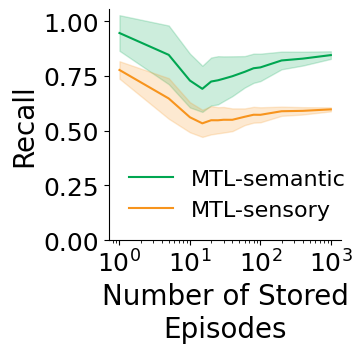

In [44]:
recall_semantic_intact = torch.stack(results["recall_semantic"][:num_seeds])
recall_sensory_intact = torch.stack(results["recall_sensory"][:num_seeds])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
semantic_mean = recall_semantic_intact.mean(axis=0).squeeze(1)
semantic_std  = recall_semantic_intact.std(axis=0).squeeze(1)

sensory_mean  = recall_sensory_intact.mean(axis=0).squeeze(1)
sensory_std   = recall_sensory_intact.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# semantic
plt.plot(x, semantic_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    semantic_mean - semantic_std,
    semantic_mean + semantic_std,
    color=green,
    alpha=0.2
)

# sensory
plt.plot(x, sensory_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    sensory_mean - sensory_std,
    sensory_mean + sensory_std,
    color=orange,
    alpha=0.2
)

plt.legend(frameon=False, fontsize=16)
plt.xscale("log")
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d_supp.svg', dpi=300, transparent=True)

<Figure size 300x300 with 0 Axes>

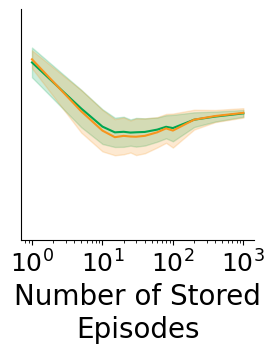

In [45]:
fig = plt.figure(figsize=((3, 3)))
recall_semantic_scrambled = torch.stack(results["recall_semantic"][num_seeds:])
recall_sensory_scrambled = torch.stack(results["recall_sensory"][num_seeds:])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
semantic_mean = recall_semantic_scrambled.mean(axis=0).squeeze(1)
semantic_std  = recall_semantic_scrambled.std(axis=0).squeeze(1)

sensory_mean  = recall_sensory_scrambled.mean(axis=0).squeeze(1)
sensory_std   = recall_sensory_scrambled.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# semantic
plt.plot(x, semantic_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    semantic_mean - semantic_std,
    semantic_mean + semantic_std,
    color=green,
    alpha=0.2
)

# sensory
plt.plot(x, sensory_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    sensory_mean - sensory_std,
    sensory_mean + sensory_std,
    color=orange,
    alpha=0.2
)


plt.xscale("log")
plt.yticks([])
plt.ylim([0, 1])


plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
#plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d2_supp.svg', dpi=300, transparent=True)

In [46]:


network = torch.load("checkpoints/network_5_blocked_median.pt", weights_only=False)
num_episodes = 1

seed_everything(0)

input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 5 * num_episodes
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input, input_episodes, input_latents, network = test_network(
    network, input_params, sleep=False, print_rate=np.inf
)


0


In [47]:
num_cpu = 100
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [48]:
experiment_params = [(network_parameters, recording_parameters, input_params, latent_specs, seed) for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(sensory_semantic_replay, experiment_params)

starting simulation - 0
starting simulation - 1
starting simulation - 2
starting simulation - 3starting simulation - 4

starting simulation - 5
starting simulation - 6
starting simulation - 7
starting simulation - 9
starting simulation - 8
starting simulation - 10
starting simulation - 11starting simulation - 12starting simulation - 14
starting simulation - 13

starting simulation - 15

starting simulation - 18starting simulation - 16starting simulation - 17
starting simulation - 19starting simulation - 20starting simulation - 21
starting simulation - 22




starting simulation - 24starting simulation - 23starting simulation - 27starting simulation - 25

starting simulation - 26

starting simulation - 29starting simulation - 30
starting simulation - 28

starting simulation - 32
starting simulation - 31
starting simulation - 35starting simulation - 34starting simulation - 36starting simulation - 33

starting simulation - 37starting simulation - 40starting simulation - 38





starting s

In [49]:
def save_results(results_list, filename):


    results = {}
    results["selectivity_mtl_semantic"] = []
    results["accuracy_mtl_semantic_1"] = []
    results["accuracy_mtl_semantic_2"] = []


    for selectivity_mtl_semantic, accuracy_1, accuracy_2 in results_list:


        results["selectivity_mtl_semantic"].append(selectivity_mtl_semantic)
        results["accuracy_mtl_semantic_1"].append(accuracy_1)
        results["accuracy_mtl_semantic_2"].append(accuracy_2)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_sensory_semantic.pickle')

In [50]:
with open('Data/{}'.format('fig_6_sensory_semantic.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


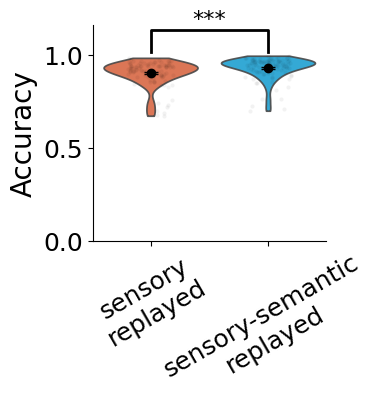

In [57]:



# Flatten arrays
acc_pre_c = np.array(results["accuracy_mtl_semantic_1"]).flatten()
acc_post_c = np.array(results["accuracy_mtl_semantic_2"]).flatten()


dist1 = ('sensory\nreplayed', acc_pre_c)
dist2 = ('sensory-semantic\nreplayed', acc_post_c)

palette = {
    "sensory\nreplayed": red,   # light blue
    "sensory-semantic\nreplayed": blue
}

compare_distributions_12(dist1, dist2, palette, size=(3, 2.8))
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)

sns.despine()


plt.savefig('Figures_SVG/6f.svg', dpi=300, transparent=True)

In [52]:
median_seed = np.argsort(np.array(results["accuracy_mtl_semantic_2"]).mean(axis=1))[num_seeds//2]
best_seed = np.argsort(np.array(results["accuracy_mtl_semantic_2"]).mean(axis=1))[-1]

In [53]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = sensory_semantic_replay(network_parameters, recording_parameters, input_params, latent_specs, seed=int(best_seed), get_network=True)
network.selectivity_ctx = selectivity_ctx
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_6_best.pt")

starting simulation - 46
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
0
50
100
150
200
250
300
350
400
450
0
50


In [54]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = sensory_semantic_replay(network_parameters, recording_parameters, input_params, latent_specs, seed=int(median_seed), get_network=True)
network.selectivity_ctx = selectivity_ctx
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_6_median.pt")

starting simulation - 17
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
0
50
100
150
200
250
300
350
400
450
0
50
